In [27]:
# Import libraries and dependencies
import numpy as np
import pandas as pd
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
%matplotlib inline

In [28]:
np.random.seed(42)

# Portfolio Planner

In this activity, you will use the Alpaca api to grab historical data for a 60/40 portfolio using `SPY` to represent the stock portion and `AGG` to represent the bonds.

In [29]:
# Load .env enviroment variables
from dotenv import load_dotenv
load_dotenv()

# Set Alpaca API key and secret
alpaca_api_key = "PKQ0EQ43YZ8AQG0TEX3B"#os.getenv("ALPACA_API_KEY")
alpaca_secret_key = "N9PUxnUxw9m7D6/E0Oreh3TUHcMkPpfNA8n5SHZO"#os.getenv("ALPACA_SECRET_KEY")

# api = tradeapi.REST()
api = tradeapi.REST(alpaca_api_key, alpaca_secret_key, api_version='v2')

# Data Collection

In this step, you will need to use the Alpaca api to fetch closing prices for the `SPY` and `AGG` tickers. Save the results as a pandas DataFrame

In [30]:
list_of_tickers = ["SPY", "AGG"]
barset = api.get_barset(list_of_tickers, 'day', limit = 252)
spy_bars = barset['SPY']
spy_close = []
for bar in spy_bars:
    spy_close.append(bar.c)
agg_bars = barset['AGG']
agg_close = []
for bar in agg_bars:
    agg_close.append(bar.c)
df = pd.DataFrame({'SPY': spy_close, 'AGG': agg_close})
df

,SPY,AGG
0,286.7500,108.570
1,288.0300,108.670
2,280.9905,108.670
3,283.3300,108.860
4,285.0600,108.940
...,...,...
247,282.7300,116.900
248,283.6600,116.975
249,286.2200,116.880
250,284.2900,116.450


# Monte Carlo Simulation

In this step, you will run Monte Carlo Simulations for your portfolio to model portfolio performance at different retirement ages. 

Complete the following steps:
1. Calculate the daily returns for the SPY and AGG closing prices.
2. Calculate volatility for both the SPY and AGG closing prices.
3. Find the last day's closing price for both stocks and save those as variables.
4. Run a Monte Carlo Simulation of at least 500 iterations and generate at least 30 years of closing prices

### HINTS:
There are 252 trading days per year, so the number of records to generate for each Monte Carlo run will be 252 days * 30 years

In [31]:
# Calculate the daily roi for the stocks
daily_returns = df.pct_change()
daily_returns.head()

,SPY,AGG
0,NaN,NaN
1,0.004464,0.000921
2,-0.024440,0.000000
3,0.008326,0.001748
4,0.006106,0.000735


In [32]:
spy_avg_daily_return = daily_returns.mean()['SPY']
spy_avg_daily_return

0.0002218583649220266

In [33]:
agg_avg_daily_return = daily_returns.mean()['AGG']
agg_avg_daily_return

0.0003044809925834281

In [34]:
# Calculate volatility
spy_std_dev_daily_return = daily_returns.std()['SPY']
spy_std_dev_daily_return

0.020379813257032014

In [35]:
agg_std_dev_daily_return = daily_returns.std()['AGG']
agg_std_dev_daily_return

0.0055924939690647595

In [36]:
# Save the last day's closing price
spy_last_price = df['SPY'].iloc[-1]
agg_last_price = df['AGG'].iloc[-1]

In [37]:
# Setup the Monte Carlo Parameters
number_simulations = 500
number_records = 252 * 30
monte_carlo = pd.DataFrame()
weights = [0.60, 0.40]
simulated_cumulative_returns = pd.DataFrame()

In [38]:
# Run the Monte Carlo Simulation
for x in range(number_simulations):
    
    simulated_spy_prices = [spy_last_price]
    simulated_agg_prices = [agg_last_price]
    
    for i in range(number_records):
        simulated_spy_price = simulated_spy_prices[-1] * (1 + np.random.normal(spy_avg_daily_return, spy_std_dev_daily_return))
        simulated_agg_price = simulated_agg_prices[-1] * (1 + np.random.normal(agg_avg_daily_return, agg_std_dev_daily_return))
   
        simulated_spy_prices.append(simulated_spy_price)
        simulated_agg_prices.append(simulated_agg_price)
        
    monte_carlo["SPY Prices"] = pd.Series(simulated_spy_prices)
    monte_carlo["AGG Prices"] = pd.Series(simulated_agg_prices)
    
    simulated_daily_returns = monte_carlo.pct_change()
    
    portfolio_cumulative_returns = simulated_daily_returns.dot(weights)
    
    simulated_cumulative_returns[x] = (1 + portfolio_cumulative_returns.fillna(0)).cumprod()

simulated_cumulative_returns.head()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.006019,0.987987,0.981692,0.998049,1.013323,1.016405,1.022843,0.989608,1.003510,0.996646,...,1.004333,0.987812,1.017450,0.998857,0.992880,1.006791,0.989154,0.983243,1.006730,0.991960
2,1.017671,0.996790,0.978839,0.994261,1.020587,0.991778,1.007238,0.961422,1.000297,1.017040,...,1.008642,1.005363,1.024357,1.002001,0.995391,0.997368,0.986796,0.983276,1.005360,1.000499
3,1.014483,0.995793,0.986658,0.978388,1.017733,0.998424,1.016162,0.945304,0.998631,1.037256,...,1.007630,1.011164,1.035392,1.004775,0.977400,0.993123,0.995252,0.996340,1.012956,0.996452
4,1.036074,1.002139,0.976564,0.992058,1.020591,0.984583,1.011928,0.937345,1.017770,1.009628,...,1.011358,1.005504,1.030522,1.016855,0.991921,0.984366,0.979748,0.997098,1.023562,1.004331


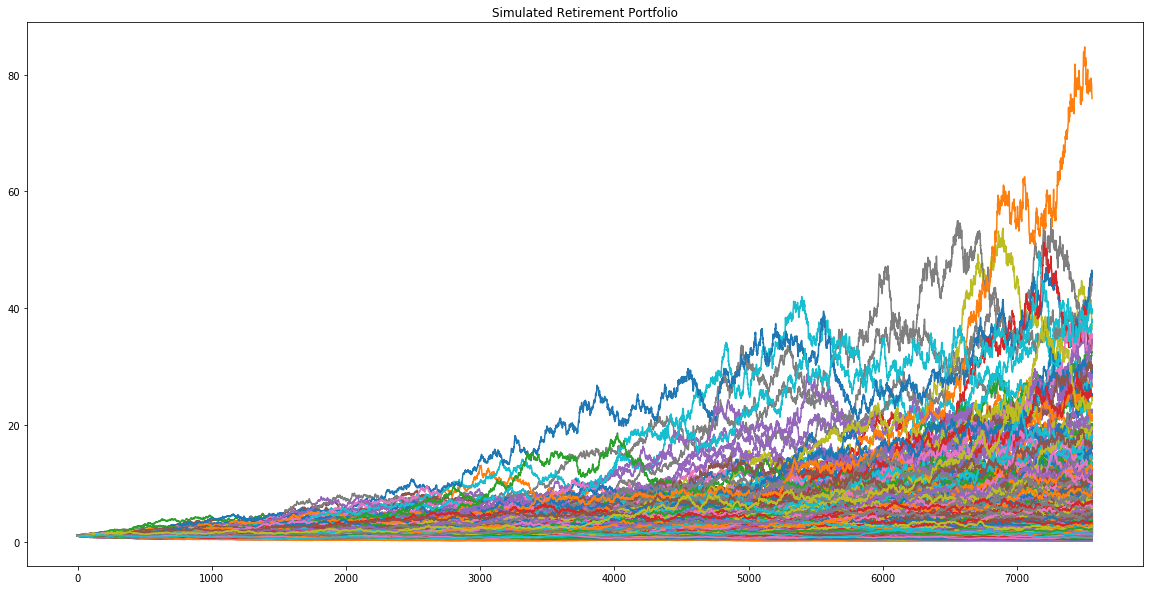

In [39]:
# Visualize the Simulation
plot_title = "Simulated Retirement Portfolio"
simulated_cumulative_returns.plot(legend=None, title=plot_title, figsize=(20,10))

In [40]:
# Select the last row for the cumulative returns (cumulative returns at 30 years)
final_cumulative_returns = simulated_cumulative_returns.iloc[-1, :]
final_cumulative_returns.head()

0    5.518285
1    3.329062
2    7.636190
3    8.634136
4    6.743696
Name: 7560, dtype: float64

In [41]:
# Display the 90% confidence interval for the ending returns
final_cumulative_returns.value_counts(bins=50) / len(final_cumulative_returns)
confidence_interval = final_cumulative_returns.quantile(q=[0.05, 0.95])
confidence_interval

0.05     0.572124
0.95    21.041365
Name: 7560, dtype: float64

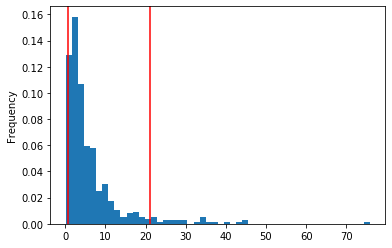

In [42]:
# Visualize the distribution of the ending returns
plt.figure();
final_cumulative_returns.plot(kind='hist', density=True, bins=50)
plt.axvline(confidence_interval.iloc[0], color='r')
plt.axvline(confidence_interval.iloc[1], color='r')

---

# Retirement Analysis

In this section, you will use the monte carlo model to answer the following retirement planning questions:

1. What are the expected cumulative returns at 30 years for the 10th, 50th, and 90th percentiles?
2. Given an initial investment of `$20,000`, what is the expected portfolio return in dollars at the 10th, 50th, and 90th percentiles?
3. Given the current projected annual income from the Plaid analysis, will a 4% withdraw rate from the retirement portfolio meet or exceed that value at the 10th percentile?
4. How would a 50% increase in the initial investment amount affect the 4% retirement withdrawal?

### What are the expected cumulative returns at 30 years for the 10th, 50th, and 90th percentiles?

In [43]:
tenth_percentile = final_cumulative_returns.quantile(q=0.1)
fiftieth_percentile = final_cumulative_returns.quantile(q=0.5)
ninetieth_percentile = final_cumulative_returns.quantile(q=0.9)

print(tenth_percentile, fiftieth_percentile, ninetieth_percentile)

1.013659186237693 3.592012304672525 13.453700807741466


### Given an initial investment of `$20,000`, what is the expected portfolio return in dollars at the 10th, 50th, and 90th percentiles?

In [44]:
initial_investment = 20000

tenth_percentile_return = tenth_percentile * initial_investment
fiftieth_percentile_return = fiftieth_percentile * initial_investment
ninetieth_percentile_return = ninetieth_percentile * initial_investment

print(tenth_percentile_return, fiftieth_percentile_return, ninetieth_percentile_return)

20273.183724753857 71840.24609345049 269074.0161548293


### Given the current projected annual income from the Plaid analysis, will a 4% withdraw rate from the retirement portfolio meet or exceed that value at the 10th percentile?

Note: This is effectively saying that 90% of the expected returns will be greater than the return at the 10th percentile, so this can help measure the uncertainty about having enough funds at retirement

In [45]:
yearly_salary = 7389.0
withdrawal_rate = 0.04
projected_withdrawal = tenth_percentile_return * withdrawal_rate

print('projected_withdrawal is', projected_withdrawal, " and is ")

if projected_withdrawal > yearly_salary:
    print("greater than ", yearly_salary)

elif projected_withdrawal < yearly_salary:
    print("less than ", yearly_salary)
    
else:
    print("equal to ", yearly_salary)

projected_withdrawal is 810.9273489901543  and is 
less than  7389.0


### How would a 50% increase in the initial investment amount affect the 4% retirement withdrawal?

In [46]:
new_investment = initial_investment * 1.5
tenth_percentile_return_new = tenth_percentile * new_investment
projected_withdrawal_new = tenth_percentile_return_new * withdrawal_rate

print('the projected retirement withdraw increased by', projected_withdrawal_new - projected_withdrawal, \
      " from ", projected_withdrawal, ' to ', projected_withdrawal_new)

the projected retirement withdraw increased by 405.4636744950774  from  810.9273489901543  to  1216.3910234852317


### Optional Challenge

In this section, you will calculate and plot the cumulative returns for the median and 90% confidence intervals. This plot shows the expected cumulative returns for any given day between the first day and the last day of investment. 

In [47]:
# YOUR CODE HERE